In [2]:
import sys,os,signal
import os.path

from numpy import *
from stats.transform import stft,standardise
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score
from matplotlib.pyplot import *
%matplotlib inline

In [2]:
# os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES']='3'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 6, 'pin_memory': True, 'worker_init_fn': worker_init}
fs = 44100

m = 128
k = 500
d = 4096
window = 5*fs
stride = 512
regions = 1 + (window - d)/stride

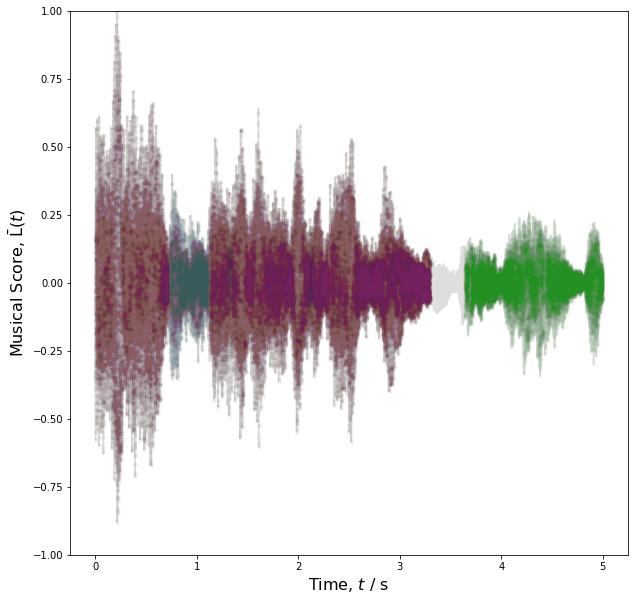

In [55]:
with musicnet.MusicNet() as data:
    audio,label = data[1]

    time = linspace(0,data.window,audio.size)/data.sample_frequency
    t,f,s = stft(audio,time)
    
    figure(figsize=(10,10))
    
    for inst in xrange(11):
        inst_mask = amax(label[:,:,inst],axis=1).todense().astype(bool)
        plot(time, audio/amax(audio),'k',alpha=0.01) 
        plot(time[inst_mask], audio[inst_mask]/amax(audio),'.',alpha=0.01)
    
    xlabel(r'Time, $t$ / s',fontsize=16)
    ylabel(r'Musical Score, $\bar{\mathrm{L}}(t)$',fontsize=16)
    ylim(-1,1)
    
Audio(audio,rate=44100)

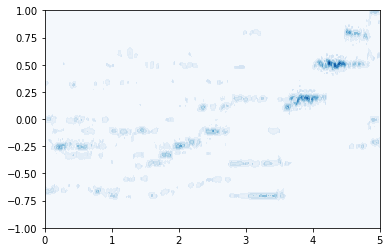

In [60]:
contourf(z,cmap='Blues',vmin=0,
        extent=(0,data.window/data.sample_frequency,-1,1),
        alpha=0.5)

In [59]:
z = abs(s)/sum(abs(s),axis=0)

In [ ]:
s

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [ ]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [ ]:
wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand(regions*k,m).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) \
       + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

# Train the model

In [ ]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [ ]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print 'square loss\tavg prec\ttime\t\tutime'
        for epoch in xrange(50):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                optimizer.zero_grad()
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(forward(x,*weights),y,*weights)
                loss.backward()
                optimizer.step()

                for w,wavg in zip(weights, averages):
                    wavg.copy_(avg*wavg + (1.-avg)*w)

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            for i, (x, y) in enumerate(test_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                yhatvar = forward(x,*averages)
                loss += L(yhatvar,y,*averages).data[0]
                yground[i*batch_size:(i+1)*batch_size,:] = y.data
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print '{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1)

except KeyboardInterrupt:
    print 'Graceful Exit'
else:
    print 'Finished'

In [ ]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])